# Derivatives

# Cells that help you with your questions in Asg-7 are AT THE VERY END
  

## You may wish to watch the video before embarking on this work.


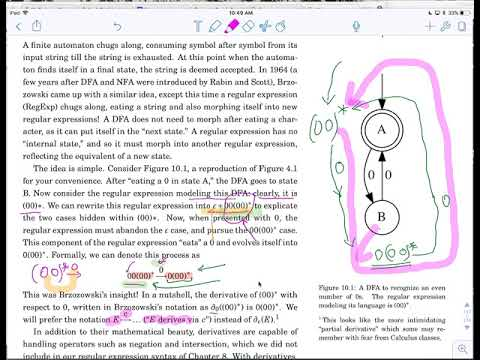

In [1]:
# This Youtube video walks through this notebook

from IPython.display import YouTubeVideo
YouTubeVideo('xGvCjoWemWg')

 ## The CFG for REs used in this exercise is below


expression -> expression PLUS catexp

catexp -> catexp andexp | andexp 

andexp -> andexp AND ordyexp | ordyexp

ordyexp -> str | eps | LPAREN expression RPAREN | ordyexp STAR | NOT ordyexp


In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import sys

# -- Detect if in Own Install or in Colab
try:
    import google.colab
    OWN_INSTALL = False
except:
    OWN_INSTALL = True
    
if OWN_INSTALL:
    
  #---- Leave these definitions ON if running on laptop
  #---- Else turn OFF by putting them between ''' ... '''

  sys.path[0:0] = ['../../../../..',  '../../../../../3rdparty',  
                   '../../../..',  '../../../../3rdparty',  
                   '../../..',     '../../../3rdparty', 
                   '../..',        '../../3rdparty',
                   '..',           '../3rdparty' ]

else: # In colab
  ! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
  sys.path.append('./Jove')
  sys.path.append('./Jove/jove')

# -- common imports --
from jove.lex import lex
from jove.yacc import yacc
from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from jove.SystemImports       import *
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)



## Token definitions

This is the lexer for REs. We begin with token definitions

**NOTE** 

### * We leave it as an exercise for you to add the token for negation and conjunction

### i.e. support things like !a for negation and !a & b for conjunction


In [3]:
tokens = ('EPS','STR','LPAREN','RPAREN','PLUS','STAR', 'NOT', 'AND')

# Tokens
t_PLUS    = r'\+'
t_STAR    = r'\*'
t_LPAREN  = r'\('
t_RPAREN  = r'\)'
t_EPS     = r'\'\'|\"\"'  
t_STR     = r'[a-zA-Z0-9]'

t_NOT     = r'\!' # <== pattern for NOT  - new to RE
t_AND     = r'\&' # <== pattern for AND  - new to RE

# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    
# Build the lexer, if necessary, right here.
# lex()  #-- not needed for us.

### These parsing rules specify many things. 

We begin with operator precedence rules that are essentially to help the "LALR parser" (also known as the bottom-up parser) resolve 'shift-reduce conflicts'.

In [4]:
# Parsing rules

# A4J: Suggested new precedence rules for AND and NOT are in comments below.
# Uncomment the AND and NOT lines in your extension
# 
precedence = (
   ('left','PLUS'),
   ('left', 'AND'),   #<== Note where AND sits
   ('left','STAR'),
   ('right','NOT')    #<== Note where NOT sits
   )

## CFG productions and semantic actions

These Python functions whose names begin with "p_" house (1) the CFG production rules within their documentation strings. (2) the semantic actions within their body. The semantic actions can refer to grammar symbol attributes within CFG productions. We will explain one of these rules now.

Take the rules 

 expression -> expression PLUS catexp
 expression -> catexp
 
1) This function defines the first production rule

def p_expression_plus(t):

   a) This comment string expresses the production rule
   
    '''expression : expression PLUS catexp'''
    
   b) This line below tells us that the occurrence of 'expression' on
      the left-hand side is marked t[0], and its value is determined by
      applying function attrDyadicInfix onto its three arguments below.
      Here, t[1] is the attribute of 'expression' coming after the colon (:)
      and the attribute of catexp is t[3]
      
    t[0] = attrDyadicInfix("+", t[1], t[3])    
    
2) This function expresses the second related production rule where the
   basis case 
    
def p_expression_plus1(t):
    '''expression : catexp'''

    t[0] = t[1]  

In [5]:
def p_expression_plus(t):
    'expression : expression PLUS catexp'
    #
    t[0] = attrDyadicInfix("+", t[1], t[3])    
    
def p_expression_plus1(t):
    'expression : catexp'
    #
    t[0] = t[1]  

In [6]:

def p_expression_cat(t):
    'catexp :  catexp andexp'
    #
    t[0] = attrDyadicInfix(".", t[1], t[2])

def p_expression_cat1(t):
    'catexp :  andexp'
    #
    t[0] = t[1]  

def p_expression_ordy(t):          #<== CHECK THESE  
    'andexp : andexp AND ordyexp'  #<==  
    #
    t[0] = attrDyadicInfix("&", t[1], t[3])


def p_expression_ordy1(t):
    'andexp : ordyexp'
    #
    t[0] = t[1]
    

# We employ field 'ast' of the dict to record the abstract syntax tree. 
# Field 'dig' holds a digraph. It too is a dict. 
# Its fields are nl for the node list and el for the edge list

def p_expression_ordy_star(t):
    'ordyexp : ordyexp STAR'
    #
    ast = ('*', t[1]['ast'])

    nlin = t[1]['dig']['nl']
    elin = t[1]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("R*_") 
    right = NxtStateStr("*_")

    t[0] = {'ast' : ast,
            'dig' : {'nl' : [root] + nlin + [right], # this order important for proper layout!
                     'el' : elin + [ (root, rootin),
                                     (root, right) ]
                    }}




 

def p_expression_ordy_not(t):     #<== Note how we added NOT
    'ordyexp : NOT ordyexp'
    #
    ast  = ('!', t[2]['ast'])
    
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("!R_") 
    left = NxtStateStr("!_")

    t[0] = {'ast' : ast,
            'dig' : {'nl' : [ root, left ] + nlin, # this order important for proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin) ]
                    }}



def p_expression_ordy_paren(t):
    'ordyexp : LPAREN expression RPAREN'
    #
    ast  = t[2]['ast']
    
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("(R)_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] = {'ast' : ast,
            'dig' : {'nl' : [root, left] + nlin + [right], 
                     'el' : elin + [ (root, left),
                                     (root, rootin),
                                     (root, right) ]
                    }}

def p_expression_ordy_eps(t):
    'ordyexp : EPS'
    #
    strn = '@'
    ast  = ('@', strn)           
    t[0] = { 'ast' : ast,
             'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                      'el' : []
                     }}          
    
def p_expression_ordy_str(t):
    'ordyexp : STR'
    #
    strn = t[1]
    ast  = ('str', strn)
    t[0] = {'ast' : ast,
            'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                     'el' : [] 
                    }}

def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
    
def attrDyadicInfix(op, attr1, attr3):         # <== this is what prints the parse-tree
    ast  = (op, (attr1['ast'], attr3['ast']))  # <== for an infix operator
    
    nlin1 = attr1['dig']['nl']
    nlin3 = attr3['dig']['nl']
    nlin  = nlin1 + nlin3
    
    elin1 = attr1['dig']['el']
    elin3 = attr3['dig']['el']
    elin  = elin1 + elin3
    
    rootin1 = nlin1[0]
    rootin3 = nlin3[0]    
    
    root   = NxtStateStr("R1"+op+"R2"+"_") # NxtStateStr("$_")
    left   = rootin1
    middle = NxtStateStr(op+"_")
    right  = rootin3
    
    return {'ast' : ast,
            'dig' : {'nl' : [ root, left, middle, right ] + nlin,
                     'el' : elin + [ (root, left),
                                     (root, middle),
                                     (root, right) ]
                     }}

#===
# This is the main function in this Jove file. Give
#===

def parseRE(s):
    """In: a string s containing a regular expression.
       Out: An attribute triple consisting of
            1) An abstract syntax tree suitable for processing in the derivative-based scanner
            2) A node-list for the parse-tree digraph generated. Good for drawing a parse tree 
               using the drawPT function below
            3) An edge list for the parse-tree generated (again good for drawing using the
               drawPT function below)
    """
    mylexer  = lex()
    myparser = yacc()
    pt = myparser.parse(s, lexer = mylexer)             # <== pass the right lexer into the parser
    return (pt['ast'], pt['dig']['nl'], pt['dig']['el']) # <== the parser returns the parse-tree
                                                        # <== as a Python data structure, plus a tree data structure for drawing

In [7]:
def drawPT(ast_nl_el, comment="PT"):
    """Given an (ast, nl, el) triple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object.
    """
    (ast, nl, el) = ast_nl_el
    print("Drawing AST for ", ast)
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return dotObj_pt

# You can draw parse-trees as before

Drawing AST for  ('+', (('str', '0'), ('.', (('str', '1'), ('*', ('str', '1'))))))


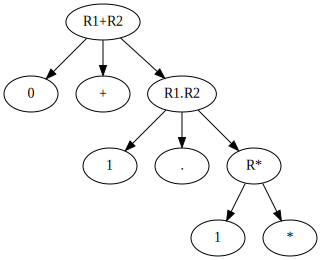

In [8]:
drawPT(parseRE("0+11*"))

# You can draw parse-trees with & and ! also  
## Notice how the concatenation works

Drawing AST for  ('.', (('str', 'a'), ('*', ('!', ('str', 'b')))))


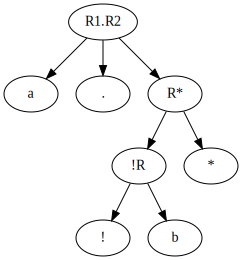

In [9]:
drawPT(parseRE("a !b*"))

## More parse-tree drawings

Drawing AST for  ('.', (('.', (('str', 'c'), ('&', (('str', 'd'), ('str', 'e'))))), ('str', 'f')))


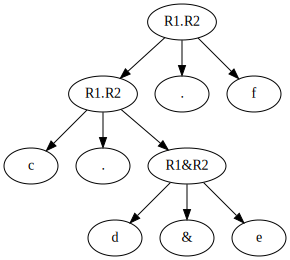

In [10]:
drawPT(parseRE("c d & e f"))

## RE with & and + involved : "a + b & c + d"  


Drawing AST for  ('+', (('+', (('str', 'a'), ('&', (('str', 'b'), ('str', 'c'))))), ('str', 'd')))


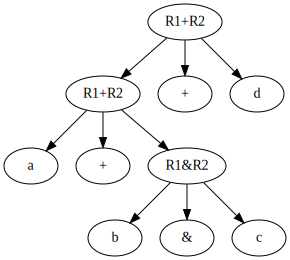

In [11]:
drawPT(parseRE("a + b & c + d"))

## RE with & and + involved : "a + !b & !c + d"  

Drawing AST for  ('+', (('+', (('str', 'a'), ('&', (('!', ('str', 'b')), ('!', ('str', 'c')))))), ('str', 'd')))


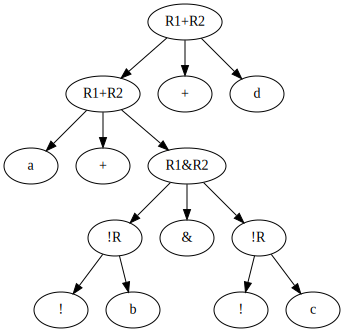

In [12]:
drawPT(parseRE("a + !b & !c + d"))

# Derivative-based Pattern Matching

## You will now be given a derivative-based pattern matcher


In [13]:
#=== Now comes derivMatch as illustration of RE Derivative scanning

# These four functions are simple extractors of the operator and arguments

def opr(E):
    """Retrieves the operator of an expression.
    """
    return E[0]

def arg1(E):
    """Retrieves the first argument of a binary operator-based expression.
    """
    return E[1][0]

def arg2(E):
    """Retrieves the second argument of a binary operator-based expression.
    """
    return E[1][1]

def arg(E):
    """Retrieves the only argument of a unary operator-based expression.
    """
    return E[1]

def nullable(E):
    """This is the nullability test defined in Chapter 10.
    """
    if (opr(E) == "str") :
        return False
    elif (opr(E) == '@') :
        return True
    elif (opr(E) == "mty") :
        return False
    elif (opr(E) == "*"):
        return True
    elif (opr(E) == "!"):                             # <== See how ! is handled
        return not nullable(arg(E))
    elif (opr(E) == '+') :
        return nullable(arg1(E)) or nullable(arg2(E))
    elif (opr(E) == '.') :
        return nullable(arg1(E)) and nullable(arg2(E))
    elif (opr(E) == '&') :                            #  <== See how & is handled
        return nullable(arg1(E)) and nullable(arg2(E))
    else:
        return "???"    

def dv(E, c):
    """This function computes the derivative
       of a regular expression E with respect
       to character "c".
    """
    if (opr(E) == "str") :
        if (arg(E) == c):
            return ('@', '@')
        else:
            return ("mty", "mty")
    elif (opr(E) == '@') :
        return ("mty", "mty")
    elif (opr(E) == "mty") :
        return ("mty", "mty")
    elif (opr(E) == "*"):
        return (".", (dv(arg(E), c), E))
    elif (opr(E) == "!"):
        return ("!", dv(arg(E), c))
    elif (opr(E) == '+') :
        return ("+", (dv(arg1(E), c), dv(arg2(E), c)))
    elif (opr(E) == '&') :
        return ("&", (dv(arg1(E), c), dv(arg2(E), c)))
    elif (opr(E) == '.') :
        if nullable(arg1(E)):
            return ("+", ( ('.', (dv(arg1(E), c), arg2(E))), dv(arg2(E), c) ))
        else:
            return ('.', (dv(arg1(E), c), arg2(E)))
    else:
        return "???"        

def matches(w, E):
    if w=="":
        return nullable(E)
    else:
        derivative = dv(E, w[0])
        return matches(w[1:], derivative)

# Let us now test pattern-matching using derivatives

## USAGE

## 1) Obtain RE = someRE

## 2) DO this: (ast, nl, el) = parseRE(RE)

## 3) CHECK nullable(ast)

## 4) CHECK matches(string, ast)

# Testing Derivative-based Parsing

## Testing Nullability

A regular expression is nullable if its language contains epsilon.
Regular-expression based pattern-matching works as follows:

* Keep obtaining the derivatives of a given RE under the characters comprising a string

* When the string is empty, check whether the RE is nullable.

### Is '' nullable?

In [14]:
# Returns the Python expression E as a tree
# Also returns the node list nl
# and the edge list el

(E, nl, el) = parseRE("''")
nullable(E)

True

### Is "c" nullable?

In [15]:
(E, nl, el) = parseRE("c")
nullable(E)

False

###  Is c* nullable?   

In [16]:
(E, nl, el) = parseRE("c*")
nullable(E)

True

In [17]:
RE1 = "(a+bc+def+bd)"
ast1_n1_e1 = parseRE(RE1)
(ast1, n1, e1) = ast1_n1_e1

In [18]:
ast1

('+',
 (('+',
   (('+', (('str', 'a'), ('.', (('str', 'b'), ('str', 'c'))))),
    ('.', (('.', (('str', 'd'), ('str', 'e'))), ('str', 'f'))))),
  ('.', (('str', 'b'), ('str', 'd')))))

In [19]:
nullable(ast1)

False

 ## More pattern-matching

In [20]:
matches("def", ast1)

True

In [21]:
RE2 = "!(a+bc+def+bd)"
ast2_n2_e2 = parseRE(RE2)
(ast2, n2, e2) = ast2_n2_e2

# TEST Pattern Matching

In [22]:
RE2 = "!(a+bc+def+bd)"
ast2_n2_e2 = parseRE(RE2)
(ast2, n2, e2) = ast2_n2_e2

In [23]:
matches("de", ast2)

True

In [24]:
RE3 = "(a+bc)&(bc+d)"
(ast3,n3,e3) = parseRE(RE3)

In [25]:
matches("bc", ast3)

True

In [26]:
RE4 = "(a+bc+def+bd)*"
(ast4, n4, e4) = parseRE(RE4)
matches("bcbcbdadef", ast4)

True

In [27]:
RE5 = "(a+!b)*"
(ast5, n5, e5) = parseRE(RE5)
matches("acca", ast5)

True

# CELLS THAT HELP YOU WITH ASG-7 are below!

# Determine whether ```(c* & !b)``` is nullable

In [28]:
# *** YOUR CODE HERE ***

# Determine whether ```(c* & b*)``` is nullable

In [29]:
# *** YOUR CODE HERE ***

# Determine (through analytical derivation) whether 
## ```(a+bc+def+bd)*``` matches the string ```bc```

# THEN TEST it out also, below


In [30]:
# *** YOUR CODE HERE ***